**Library Installation**

In [ ]:
%%capture

%pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
%pip install --no-deps cut_cross_entropy unsloth_zoo
%pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
%pip install --no-deps unsloth

**Basic Parts and Model Selection**

In [1]:
from unsloth import tokenizer_utils
def do_nothing(*args, **kwargs):
    pass
tokenizer_utils.fix_untrained_tokens = do_nothing

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
import torch
from datasets import load_dataset
import datasets
from trl import SFTTrainer
import pandas as pd
import numpy as np
import os
from unsloth import FastLanguageModel
from transformers import TrainingArguments, Trainer
from typing import Tuple, Any, Dict, List, Union
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Models that have been tested
used_models = [
    "unsloth/llama-3-8b-Instruct-bnb-4bit",   
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/gemma-2-9b-it-bnb-4bit",    
    "unsloth/Qwen2-1.5B-Instruct-bnb-4bit",
    "unsloth/Qwen2-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2.5-0.5B-Instruct-bnb-4bit",      
    "unsloth/Qwen2.5-1.5B-Instruct-bnb-4bit",
    "unsloth/Qwen2.5-3B-Instruct-bnb-4bit",   
    "unsloth/Qwen2.5-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2.5-14B-Instruct-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct-bnb-4bit",
    "unsloth/Phi-3-medium-4k-instruct-bnb-4bit",     
]

#Check CUDA device capabilities
major_version, minor_version = torch.cuda.get_device_capability()
print(f"Major Version: {major_version}, Minor Version: {minor_version}")

#Configuration
max_seq_length = 2048  #Token sequence length
dtype = None  #"None" for automatic detection

#Model configurations
model_name = "unsloth/Phi-3-mini-4k-instruct-bnb-4bit"
load_in_4bit = True  # Load the model in 4 bits

#Load the model and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name, 
    load_in_4bit=load_in_4bit,
    max_seq_length=max_seq_length,
    dtype=dtype,
)

Major Version: 8, Minor Version: 9
==((====))==  Unsloth 2025.2.12: Fast Mistral patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.533 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [3]:
#Obtain token IDs for "Yes" and "No"
yes_token_id = tokenizer.encode("Sim", add_special_tokens=False)[0]  #Yes
no_token_id = tokenizer.encode("Não", add_special_tokens=False)[0]  #No

#Create a tensor with the weights of the lm_head for the tokens "Yes" and "No"
par = torch.nn.Parameter(torch.vstack([
    model.lm_head.weight[no_token_id, :],  #Representation for class 0 (No)
    model.lm_head.weight[yes_token_id, :]  #Representation for class 1 (Yes)
]))

#Check the shapes before and after the replacement
print(f"Shape of the new parameter: {par.shape}")
print(f"Original shape of lm_head.weight: {model.lm_head.weight.shape}")

#Replace the weights of the lm_head with the new parameter
model.lm_head.weight = par

Shape of the new parameter: torch.Size([2, 3072])
Original shape of lm_head.weight: torch.Size([32064, 3072])


In [4]:
from peft import LoftQConfig

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "lm_head",
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=True,
)

print("trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Unsloth: Offloading output_embeddings to disk to save VRAM


/home/joaopedro/joaopedro/llm/lib/python3.10/site-packages/unsloth/models/_utils.py:755: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  offloaded_W = torch.load(filename, map

Unsloth: Training lm_head in mixed precision to save VRAM
trainable parameters: 29890560


**Dataset**

Dividing the dataset into training, validation and testing using stratification

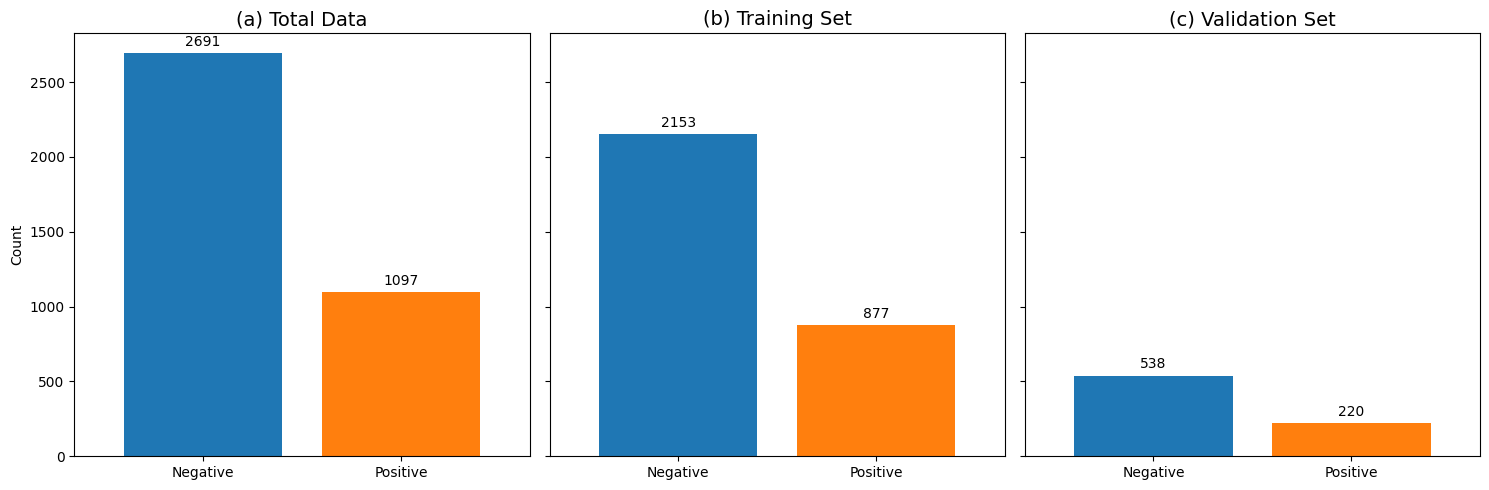

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Load the data
data = pd.read_csv("/home/joaopedro/joaopedro/llm/Mestrado/Datasets/Boamente_Treino_Atualizado.csv")

#Defining the sizes for the training and validation sets
train_size = 3030  #Number of samples in the training set
val_size = 758  #Number of samples in the validation set

#Sampling the data
data_sample = data.sample(n=train_size + val_size, random_state=24)

#Splitting the data into training and validation sets with stratification
train_df, val_df = train_test_split(
    data_sample,
    test_size=val_size / (train_size + val_size),
    random_state=24,
    stratify=data_sample['label']
)

#Function to add text labels above the bars
def add_labels(ax, df):
    for i, value in enumerate(df):
        ax.text(i, value + 30, str(value), ha='center', va='bottom', fontsize=10)

#Specific colors
colors = ['#1f77b4', '#ff7f0e']  #Soft blue and orange

#Create bar charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

#Data configuration for each chart
datasets = [('Total Data', data), ('Training Set', train_df), ('Validation Set', val_df)]
labels = ['(a)', '(b)', '(c)']

for ax, label, (title, df) in zip(axs, labels, datasets):
    counts = df['label'].value_counts().sort_index()
    counts.plot(kind='bar', ax=ax, color=colors, width=0.8)
    ax.set_title(f'{label} {title}', fontsize=14)
    ax.set_xticklabels(['Negative', 'Positive'], rotation=0)
    add_labels(ax, counts)
    ax.set_xlabel('')
    ax.set_ylabel('Count' if label == '(a)' else '')

#Adjust layout and show the chart
plt.tight_layout()
plt.show()

Show validation set data and plot the token number histogram

                                                   text  label
3187                                       vou me matar      1
2779  meu namorado da academia veio todo de preto aí...      0
3712                                  Ai é pra me matar      0
1399              maneiras de me matar google pesquisar      1
3311  essa lua em escorpião vai me matar, tenho abso...      0
...                                                 ...    ...
1582                       Eu vou cometer suicídio!!!!!      1
275   escrevendo minha carta de suicídio chorando e ...      1
79    É q a gente n quer só comida mas tamo cansado ...      0
3501  me matar pelo porr da empresa p esperarem até ...      0
3049                                       Vou me matar      1

[758 rows x 2 columns]


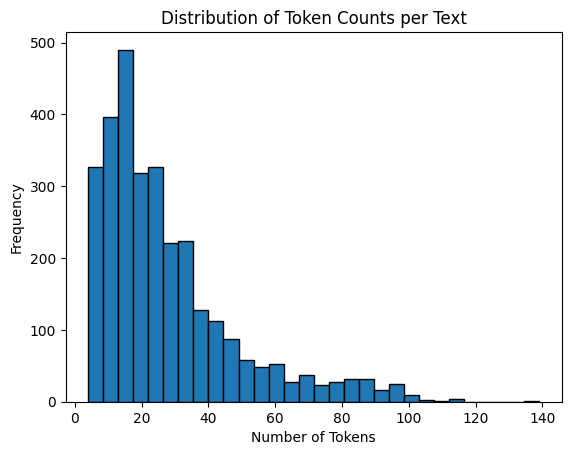

Dataset({
    features: ['text', 'label'],
    num_rows: 3030
})


In [6]:
import matplotlib.pyplot as plt
from datasets import Dataset

#Print the validation set
print(val_df)

#Count the tokens for each text in the training set
token_counts = [len(tokenizer.encode(x)) for x in train_df.text]

#Plot the histogram of token counts
plt.hist(token_counts, bins=30, edgecolor='black')
plt.title("Distribution of Token Counts per Text")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

#Convert the DataFrame into a Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
print(train_dataset)

**Prompt**

In [7]:
prompt = """Aqui está uma sentença.
{}

Se a sentença contém ideação suicida, responda "Sim". Caso contrário, responda "Não".

SOLUÇÃO
A resposta correta é: "{}"""

positivelabel = "Sim" #Yes
negativelabel = "Não" #No

# This is a sentence.
# {}
#
# If the sentence contains suicidal ideation, respond with "Yes". Otherwise, respond with "No".
#
# SOLUTION
# The correct answer is: "{}"


def formatting_prompts_func(dataset_):
    #Check the type of text
    if isinstance(dataset_['text'], str):
        #Specific adjustments for different models (Qwen, Llama, etc.)
        if 'qwen' in model_name.lower():
            return [""] * 100  #Specific case for the Qwen model
        elif 'llama' in model_name.lower():
            return " "  #Specific case for the Llama model
        else:
            return " "  #General case

    texts = []
    #Iterate through all examples in the dataset
    for i in range(len(dataset_['text'])):
        t = dataset_['text'][i]  #Extract the tweet text
        label = positivelabel if dataset_['label'][i] == 1 else negativelabel  #Determine the label
        text = prompt.format(t, label)  #Format the prompt with text and label
        texts.append(text)  #Add to the list of texts

    return texts  #Return the list of formatted prompts

Collator

In [8]:
from transformers import DataCollatorForLanguageModeling
from typing import List, Union, Dict, Any

#Custom collator to modify labels and train only on the last token
class DataCollatorForLastTokenLM(DataCollatorForLanguageModeling):
    def __init__(self, *args, mlm: bool = False, ignore_index: int = -100, **kwargs):
        #Initialize the parent class with the provided arguments
        super().__init__(*args, mlm=mlm, **kwargs)
        self.ignore_index = ignore_index  # Define the ignore_index value, which will be used to mask tokens

    def torch_call(self, examples: List[Union[List[int], Any, Dict[str, Any]]]) -> Dict[str, Any]:
        #Call the parent class function to prepare the batch of examples
        batch = super().torch_call(examples)

        #Modify the batch to train only on the last token
        for i in range(len(examples)):
            #Find the index of the last non-ignored token
            last_token_idx = (batch["labels"][i] != self.ignore_index).nonzero()[-1].item()
            #Ignore all tokens except for the last one
            batch["labels"][i, :last_token_idx] = self.ignore_index
            #Assign 1 or 0 to the last token, depending on whether it is the target token
            batch["labels"][i, last_token_idx] = 1 if batch["labels"][i, last_token_idx] == yes_token_id else 0

        return batch

#Instantiate the collator
collator = DataCollatorForLastTokenLM(tokenizer=tokenizer)

**Cross Validation Training**

In [9]:
import torch
import numpy as np
from transformers import TrainingArguments
from trl import SFTTrainer
from sklearn.model_selection import StratifiedKFold
from datasets import Dataset

#Número de folds para validação cruzada
num_folds = 5

#Converter o dataset do pandas para o formato do Hugging Face
full_dataset = Dataset.from_pandas(train_df, preserve_index=False)

#Criar os índices dos folds para validação cruzada
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=3407)

#Armazenar métricas de cada fold
all_results = []

#Iterar sobre os folds
for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset["text"], full_dataset["label"])):
    print(f"\n🚀 Iniciando Fold {fold+1}/{num_folds}...")

    #Criar os datasets para treino e validação
    train_dataset = full_dataset.select(train_idx)
    val_dataset = full_dataset.select(val_idx)

    #Definir os argumentos do treinamento
    training_args = TrainingArguments(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        warmup_steps=10,
        learning_rate=1e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
        output_dir=f"outputs/fold_{fold+1}",
        num_train_epochs=1,
        report_to="none",
        group_by_length=True,
    )

    #Criar o Trainer
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        max_seq_length=max_seq_length,
        dataset_num_proc=2,
        packing=False,
        args=training_args,
        formatting_func=formatting_prompts_func,
        data_collator=collator,
    )

    #Treinar o modelo
    trainer.train()

    #Avaliar o modelo no conjunto de validação
    metrics = trainer.evaluate()
    print(f"📊 Resultados do Fold {fold+1}: {metrics}")

    #Armazenar as métricas do fold
    all_results.append(metrics)


🚀 Iniciando Fold 1/5...


Applying formatting function to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying formatting function to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 76
 "-____-"     Number of trainable parameters = 29,890,560


Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


📊 Resultados do Fold 1: {'eval_loss': nan, 'eval_runtime': 1.8057, 'eval_samples_per_second': 335.6, 'eval_steps_per_second': 42.088}

🚀 Iniciando Fold 2/5...


Applying formatting function to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying formatting function to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 76
 "-____-"     Number of trainable parameters = 29,890,560


Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


📊 Resultados do Fold 2: {'eval_loss': nan, 'eval_runtime': 1.8039, 'eval_samples_per_second': 335.943, 'eval_steps_per_second': 42.132}

🚀 Iniciando Fold 3/5...


Applying formatting function to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying formatting function to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 76
 "-____-"     Number of trainable parameters = 29,890,560


Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


📊 Resultados do Fold 3: {'eval_loss': nan, 'eval_runtime': 1.8024, 'eval_samples_per_second': 336.211, 'eval_steps_per_second': 42.165}

🚀 Iniciando Fold 4/5...


Applying formatting function to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying formatting function to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 76
 "-____-"     Number of trainable parameters = 29,890,560


Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


📊 Resultados do Fold 4: {'eval_loss': nan, 'eval_runtime': 1.7824, 'eval_samples_per_second': 339.985, 'eval_steps_per_second': 42.638}

🚀 Iniciando Fold 5/5...


Applying formatting function to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/2424 [00:00<?, ? examples/s]

Applying formatting function to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/606 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,424 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 32 | Gradient Accumulation steps = 1
\        /    Total batch size = 32 | Total steps = 76
 "-____-"     Number of trainable parameters = 29,890,560


Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


📊 Resultados do Fold 5: {'eval_loss': nan, 'eval_runtime': 1.814, 'eval_samples_per_second': 334.065, 'eval_steps_per_second': 41.896}


**Training 80/20 only**

In [ ]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  
    args=TrainingArguments(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        warmup_steps=10,
        learning_rate=1e-4,
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
        output_dir="outputs",
        num_train_epochs=1,
        report_to="none",  
        group_by_length=True,
    ),
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

In [ ]:
trainer_stats = trainer.train()

**Model Inference**

In [11]:
FastLanguageModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32064, 3072, padding_idx=32009)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj

**Model Evaluation**

Metrics: Accuracy, Precision, Recall, F1-Score, AUC

In [12]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

#Define output directory
output_dir = "/home/joaopedro/joaopedro/llm/Mestrado/curvaROC/"
os.makedirs(output_dir, exist_ok=True)

#Load validation data
val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

#Define storage
all_probabilities = []
all_labels = []

#Step 1: Tokenization and sorting by token length
tokenized_inputs = []
for text, label in zip(val_texts, val_labels):
    test_str = prompt.format(text, "")
    tokenized_input = tokenizer(test_str, return_tensors="pt", add_special_tokens=False)
    tokenized_inputs.append((tokenized_input, test_str, label))

#Sort by tokenized length
tokenized_inputs.sort(key=lambda x: x[0]['input_ids'].shape[1])

#Step 2: Group by tokenized length
grouped_inputs = defaultdict(list)
for tokenized_input, test_str, label in tokenized_inputs:
    length = tokenized_input['input_ids'].shape[1]
    grouped_inputs[length].append((tokenized_input, test_str, label))

#Step 3: Process batches
batch_size = 64

for length, group in tqdm(grouped_inputs.items()):
    for i in range(0, len(group), batch_size):
        batch = group[i:i + batch_size]
        batch_inputs = [item[0] for item in batch]
        batch_labels = [item[2] for item in batch]

        #Concatenate batch inputs
        input_ids = torch.cat([item['input_ids'] for item in batch_inputs], dim=0).to("cuda")
        attention_mask = torch.cat([item['attention_mask'] for item in batch_inputs], dim=0).to("cuda")

        #Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        #Extract logits for classification
        logits = outputs.logits[:, -1, :2]
        probabilities = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()  #Probability of class 1

        #Store results
        all_probabilities.extend(probabilities)
        all_labels.extend(batch_labels)

#Step 4: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

# Save ROC data
np.savetxt(os.path.join(output_dir, "fpr_Phi_3.txt"), fpr)
np.savetxt(os.path.join(output_dir, "tpr_Phi_3.txt"), tpr)
np.savetxt(os.path.join(output_dir, "thresholds_Phi_3.txt"), thresholds)
with open(os.path.join(output_dir, "auc_Phi_3.txt"), "w") as f:
    f.write(f"AUC: {roc_auc:.4f}\n")

#Step 5: Find optimal threshold
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

#Step 6: Convert probabilities to binary predictions
all_outputs = (all_probabilities >= optimal_threshold).astype(int)

#Step 7: Compute evaluation metrics
cm = confusion_matrix(all_labels, all_outputs)
accuracy = accuracy_score(all_labels, all_outputs)
precision = precision_score(all_labels, all_outputs)
recall = recall_score(all_labels, all_outputs)
f1 = f1_score(all_labels, all_outputs)

#Step 8: Save all metrics + confusion matrix to a single file
metrics_file = os.path.join(output_dir, "metrics_Phi_3.txt")
with open(metrics_file, "w") as f:
    f.write("===== Model Evaluation Metrics =====\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write(f"AUC: {roc_auc:.4f}\n")
    
    f.write("\n===== Confusion Matrix =====\n")
    np.savetxt(f, cm, fmt="%d")

print(f"\nMetrics saved to: {metrics_file}")

#Step 9: Save confusion matrix separately
np.savetxt(os.path.join(output_dir, "confusion_matrix_Phi_3.txt"), cm, fmt='%d')
print("\nConfusion Matrix:")
print(cm)
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

  1%|          | 1/95 [00:00<00:13,  7.08it/s]

100%|██████████| 95/95 [00:05<00:00, 17.74it/s]

Optimal Threshold: 0.9987

Metrics saved to: /home/joaopedro/joaopedro/llm/Mestrado/curvaROC/metrics_Phi_3.txt

Confusion Matrix:
[[380 158]
 [ 94 126]]

Evaluation Metrics:
Accuracy: 0.6675
Precision: 0.4437
Recall: 0.5727
F1-Score: 0.5000
AUC: 0.6813


ROC curve and Confusion Matrix generation

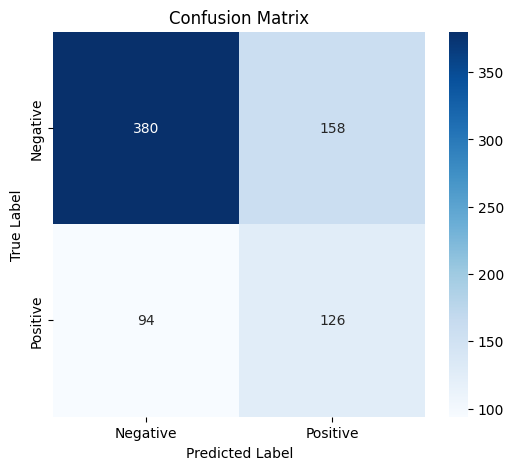

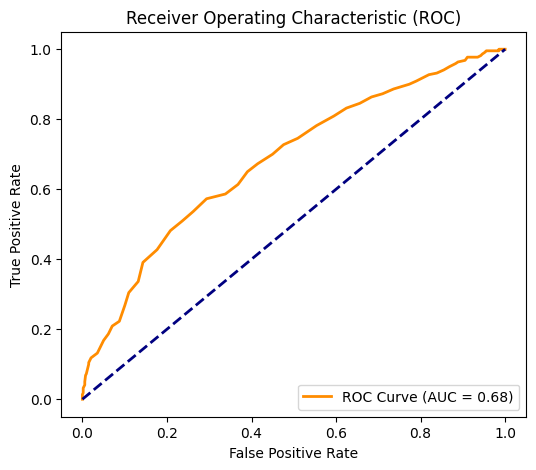

In [19]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Define the directory where the generated files are stored
output_dir = "/home/joaopedro/joaopedro/llm/Mestrado/curvaROC/"

#File names
metrics_file = os.path.join(output_dir, "metrics_Phi_3.txt")
confusion_matrix_file = os.path.join(output_dir, "confusion_matrix_Phi_3.txt")
fpr_file = os.path.join(output_dir, "fpr_Phi_3.txt")
tpr_file = os.path.join(output_dir, "tpr_Phi_3.txt")
auc_file = os.path.join(output_dir, "auc_Phi_3.txt")

#Load metrics
metrics = {}
with open(metrics_file, "r") as f:
    lines = f.readlines()
    for line in lines:
        if ":" in line:
            key, value = line.strip().split(": ")
            try:
                metrics[key.lower()] = float(value)
            except ValueError:
                pass  #Ignore non-numeric values

#Extract metric values
accuracy = metrics.get("accuracy", 0.0)
precision = metrics.get("precision", 0.0)
recall = metrics.get("recall", 0.0)
f1 = metrics.get("f1-score", 0.0)
auc_score = metrics.get("auc", 0.0)

#Load confusion matrix
cm = np.loadtxt(confusion_matrix_file, dtype=int)

#Load ROC curve data
fpr = np.loadtxt(fpr_file)
tpr = np.loadtxt(tpr_file)

#Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

#Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, "roc_curve.png"))
plt.show()

**Saving the Model**

In [ ]:
model_save_path = "/home/joaopedro/joaopedro/llm/Mestrado/Models/Qwen2_7B_finetuned" #Change the file name to the template you are running

#Save model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved at: {model_save_path}")